# Custom modules

In [12]:
import os
import sys
# Custom modules: add the 'lib' directory as one where we can import modules
# lib_src = os.path.join(os.getcwd(), os.pardir, 'src')
lib_src = '/home/mauricio/code/machine-learning'
sys.path.insert(1, lib_src)

from model_selection.multilabel import multilabel_sample_dataframe, multilabel_train_test_split, sample_report, split_report, sample_split_report
from dummies import reverse_dummies, get_dummies_indices
from size import size

# Standard data science modules

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('dark_background')

# Loading data

Sign up for an account on [DrivenData](http://www.drivendata.org/)  
Join the [Box-plots for education competition](https://www.drivendata.org/competitions/46/box-plots-for-education-reboot/)  
Download the competition datasets named `TrainingData.csv` and `TestData.csv`

In [14]:
df = pd.read_csv('/data/drivendata/TrainingData.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Function                400277 non-null  object 
 1   Use                     400277 non-null  object 
 2   Sharing                 400277 non-null  object 
 3   Reporting               400277 non-null  object 
 4   Student_Type            400277 non-null  object 
 5   Position_Type           400277 non-null  object 
 6   Object_Type             400277 non-null  object 
 7   Pre_K                   400277 non-null  object 
 8   Operating_Status        400277 non-null  object 
 9   Object_Description      375493 non-null  object 
 10  Text_2                  88217 non-null   object 
 11  SubFund_Description     306855 non-null  object 
 12  Job_Title_Description   292743 non-null  object 
 13  Text_3                  109152 non-null  object 
 14  Text_4         

# Shuffling data

In machine learning theory, i.i.d. assumption is often made for training datasets to imply that all samples stem from the same generative process and that the generative process is assumed to have no memory of past generated samples.

To ensure observations are independent and don't follow any predefined sequence, the dataset is shuffled.

That's important when using the class `sklearn.model_selection.GridSearchCV` with k-fold cross-validation which doesn't resample the dataset as per the underlying class `sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=False, random_state=None)` doesn't shuffle data by default and that could lead to biased folds.

In [15]:
df = df.sample(frac=1, replace=False, random_state=1)

# Encoding labels as category types

In [16]:
LABELS = ['Function', 'Object_Type', 'Operating_Status', 'Position_Type', 'Pre_K', 'Reporting', 'Sharing', 'Student_Type', 'Use']
FEATURES = [feature for feature in df.columns if feature not in LABELS]
print('Memory before enconding: {} ({} deep)'.format(size(df.memory_usage().sum()), size(df.memory_usage(deep=True).sum())))
df[LABELS] = df[LABELS].apply(lambda x: x.astype('category'), axis=0)
print('Memory after enconding : {} ({} deep)'.format(size(df.memory_usage().sum()), size(df.memory_usage(deep=True).sum())))

Memory before enconding: 79.4 MiB (548.5 MiB deep)
Memory after enconding : 55.4 MiB (313.0 MiB deep)


# Converting labels in dummy variables

In [17]:
# Converting labels in dummy variables
y = pd.get_dummies(df[LABELS], prefix_sep='__')
y.info()
y.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 129752 to 189020
Columns: 104 entries, Function__Aides Compensation to Use__Untracked Budget Set-Aside
dtypes: uint8(104)
memory usage: 42.8 MB


,Function__Aides Compensation,Function__Career & Academic Counseling,Function__Communications,Function__Curriculum Development,Function__Data Processing & Information Services,Function__Development & Fundraising,Function__Enrichment,Function__Extended Time & Tutoring,Function__Facilities & Maintenance,Function__Facilities Planning,...,Student_Type__Special Education,Student_Type__Unspecified,Use__Business Services,Use__ISPD,Use__Instruction,Use__Leadership,Use__NO_LABEL,Use__O&M,Use__Pupil Services & Enrichment,Use__Untracked Budget Set-Aside
129752,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
127683,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
265931,0,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
238935,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
253483,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


In [18]:
print('Size of dummy labels: {} ({} deep)'.format(size(y.memory_usage().sum()), size(y.memory_usage(deep=True).sum())))

Size of dummy labels: 42.8 MiB (42.8 MiB deep)


# Test 1: trying to stratify labels using sklearn's train_test_split()

In [19]:
from sklearn.model_selection import train_test_split
try:
    X_train, X_test, y_train, y_test = train_test_split(df[FEATURES],
                                                        y,
                                                        test_size = 0.1,
                                                        random_state=1,
                                                        stratify=y)
except ValueError as err:
    print('ValueError:', err)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.


As pointed out in **_Groups of labels with less than 2 samples (unstratifiable)_**, the y population has class groups with less than 2 observations, thefore, the standard sklearn's `train_test_split()` won't work because of those cases.

# Test 2: Large sample multi_train_test_split()

Train size`: 360250
Test size  : 40027


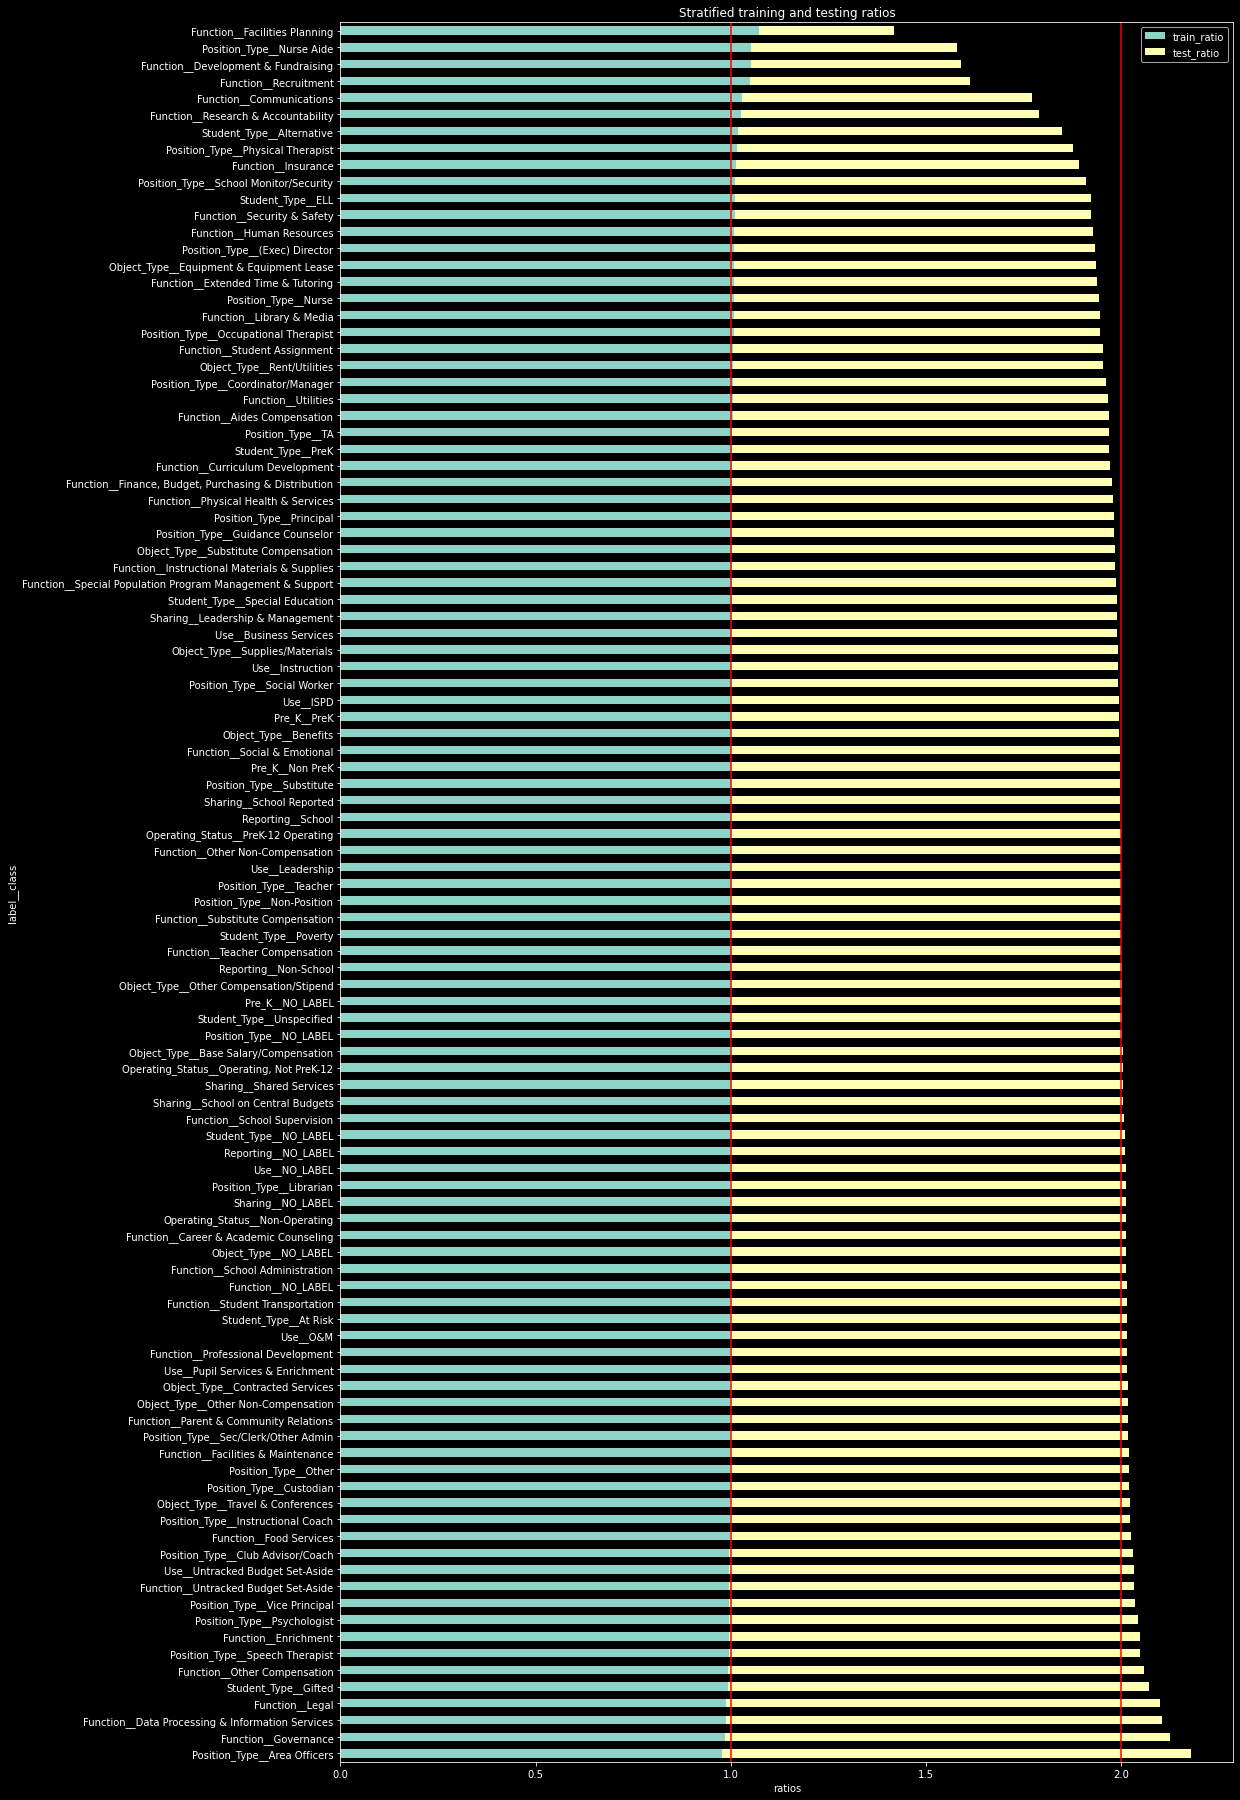

,train_ratio,test_ratio
label__class,,
Function__Facilities Planning,1.072795,0.344834
Position_Type__Nurse Aide,1.052630,0.526325
Function__Development & Fundraising,1.051372,0.537644
Function__Recruitment,1.048298,0.565312
Function__Communications,1.028527,0.743256
...,...,...
Student_Type__Gifted,0.991290,1.078389
Function__Legal,0.987652,1.111131
Function__Data Processing & Information Services,0.987005,1.116959


In [20]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[FEATURES],
                                                               y,
                                                               size=0.1,
                                                               min_count=0,
                                                               seed=1)
print('Train size`:', y_train.shape[0])
print('Test size  :', y_test.shape[0])
split_report(y, y_train, y_test)

# Test 3: Small sample multi_train_test_split()

## Stratified sample

Sample size: 4002


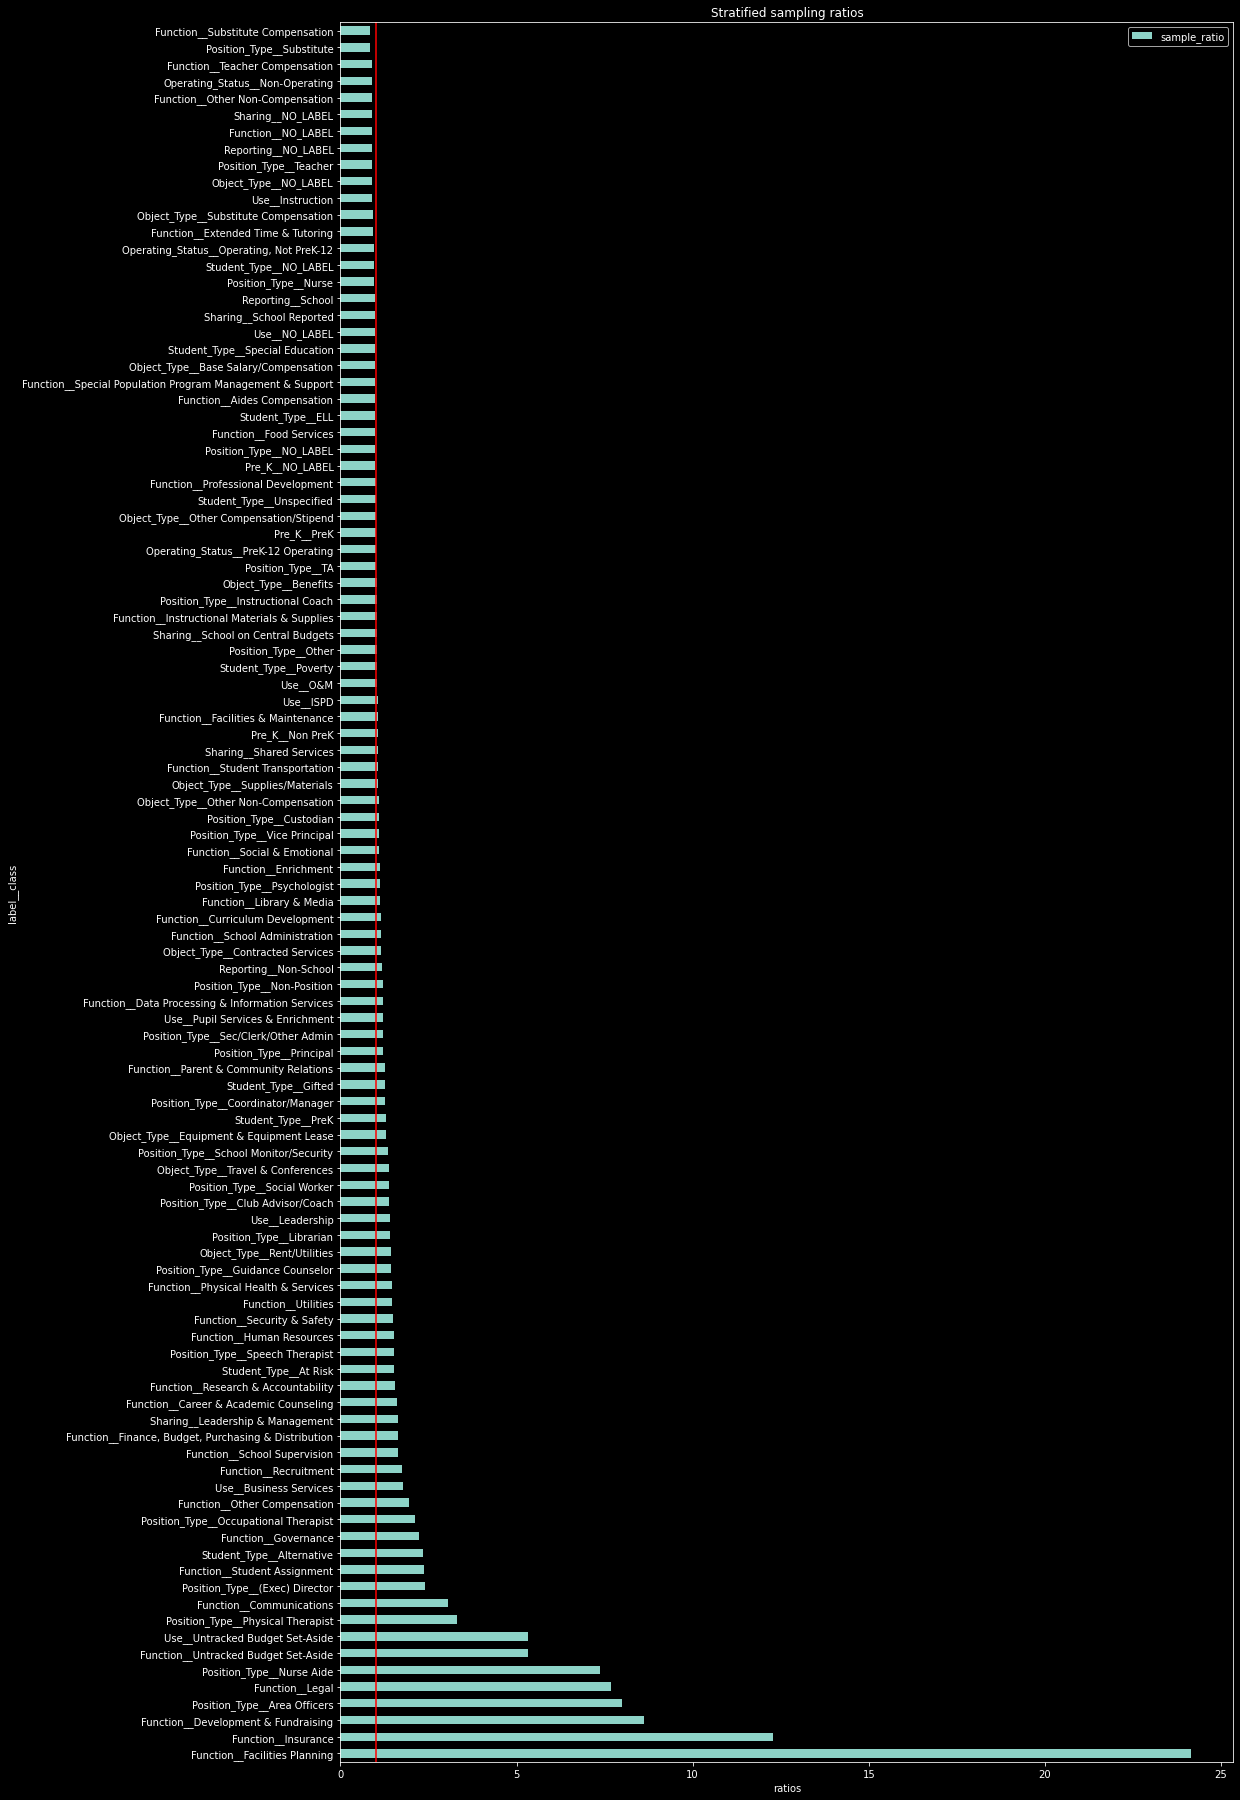

,sample_ratio
label__class,
Function__Substitute Compensation,0.844010
Position_Type__Substitute,0.851931
Function__Teacher Compensation,0.882584
Operating_Status__Non-Operating,0.882878
Function__Other Non-Compensation,0.887581
...,...
Function__Legal,7.693788
Position_Type__Area Officers,8.001539
Function__Development & Fundraising,8.603806


In [21]:
sampling = multilabel_sample_dataframe(df,
                                       y,
                                       size=0.01,
                                       min_count=7,
                                       seed=1)
dummy_labels = pd.get_dummies(sampling[LABELS], prefix_sep='__')
print('Sample size:', sampling.shape[0])
sample_report(y, dummy_labels)

## Stratified split of the stratified sample

Sample size: 4002
Train size`: 3602
Test size  : 400


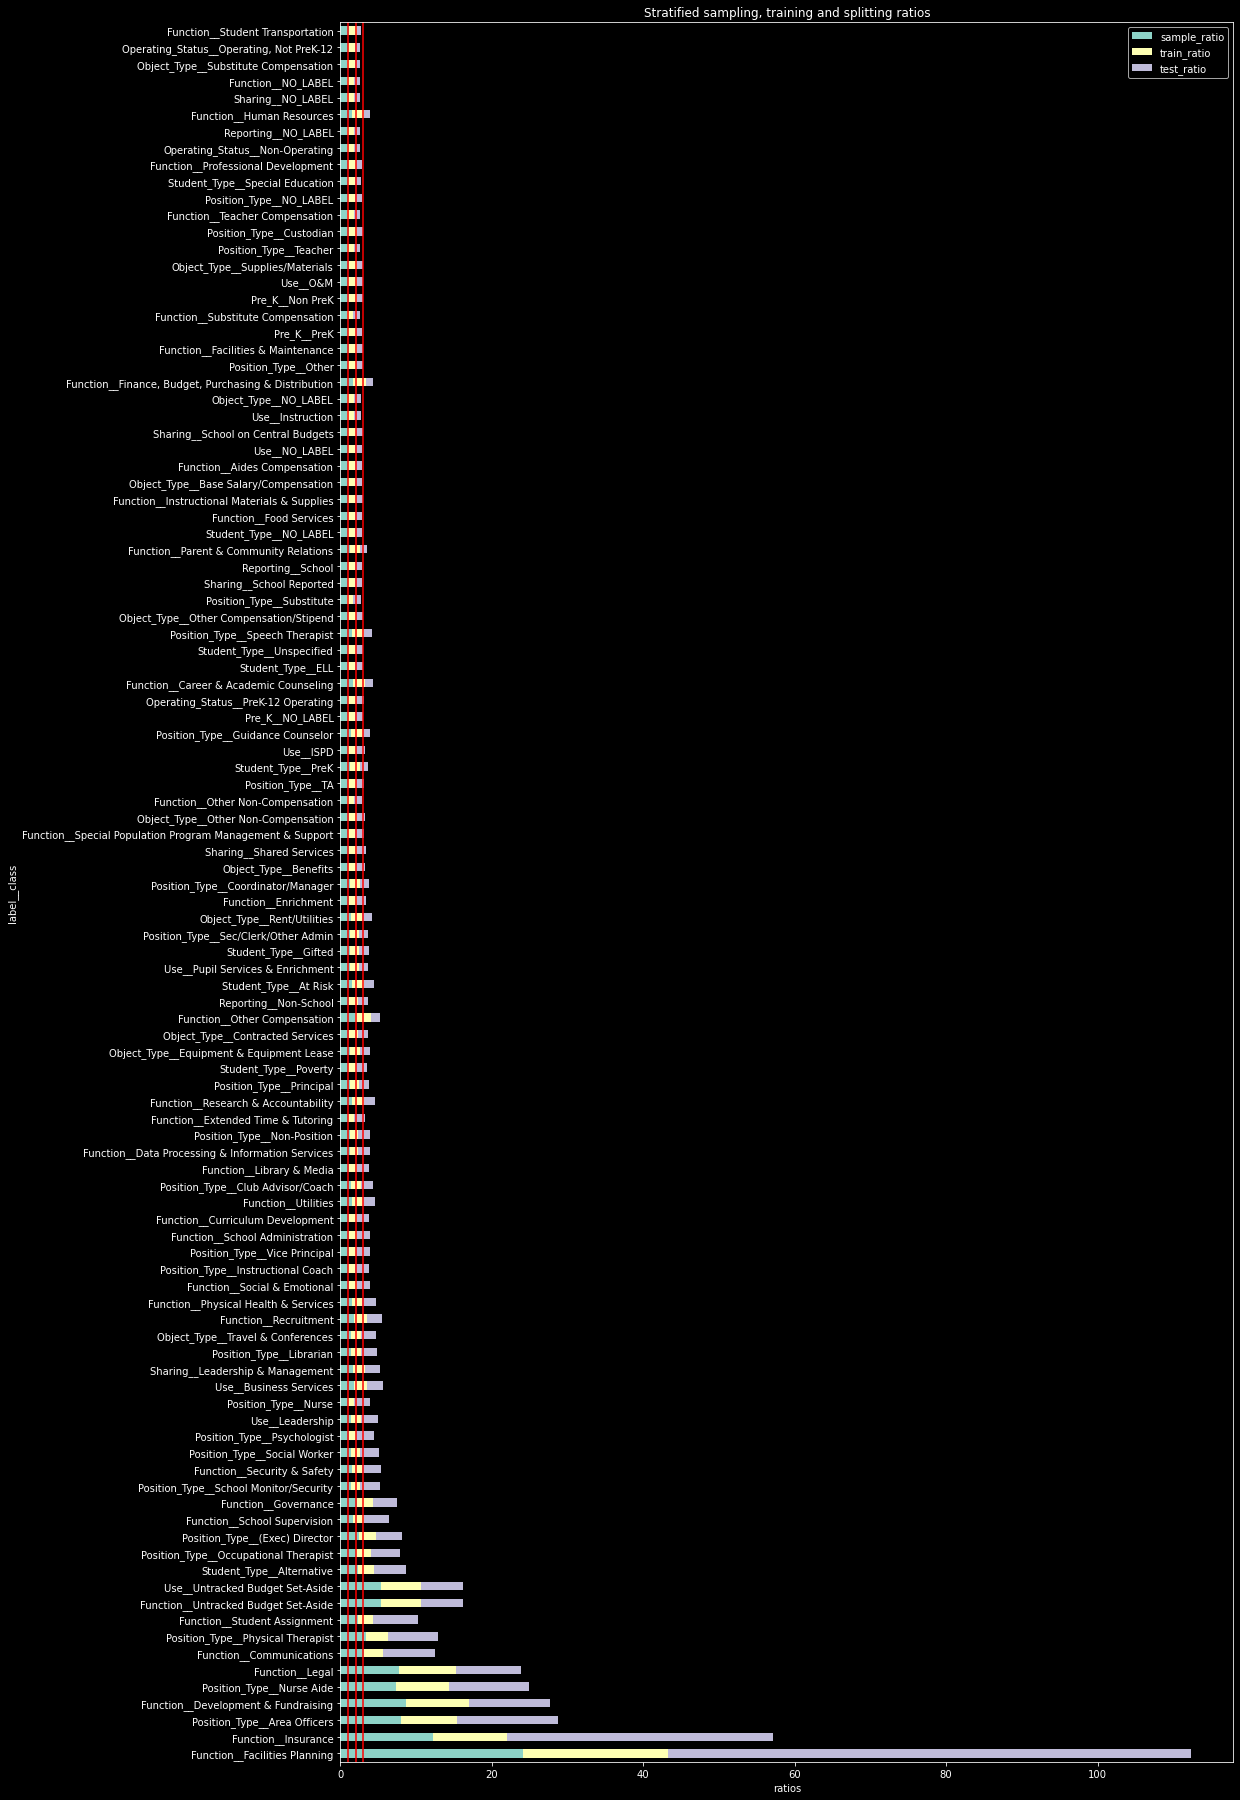

,sample_ratio,train_ratio,test_ratio
label__class,,,
Function__Student Transportation,1.071809,1.128971,0.557062
"Operating_Status__Operating, Not PreK-12",0.946518,0.974680,0.692920
Object_Type__Substitute Compensation,0.917675,0.938340,0.731581
Function__NO_LABEL,0.891425,0.906484,0.755823
Sharing__NO_LABEL,0.887735,0.902097,0.758407
...,...,...,...
Position_Type__Nurse Aide,7.369839,7.018504,10.533605
Function__Development & Fundraising,8.603806,8.364347,10.760134
Position_Type__Area Officers,8.001539,7.408421,13.342567


In [22]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(sampling[FEATURES],
                                                               dummy_labels,
                                                               size=0.1,
                                                               min_count=1,
                                                               seed=1)
print('Sample size:', sampling.shape[0])
print('Train size`:', y_train.shape[0])
print('Test size  :', y_test.shape[0])
sample_split_report(y, dummy_labels, y_train, y_test)

Here we see that some testing labels are missing after splitting.  
It's required to simultaneously optimize the `size` and `min_count` parameters on either `multilabel_sample_dataframe` and `multilabel_train_test_split`, thus, balancing the stratification the best possible to achieve the best ratio.

# Optimize sampling and splitting parameters

Run the script `optimize-sample-split.py` before continue

In [23]:
import pickle
if os.path.isfile('/data/drivendata/optimize-sample-split.pkl'):
    with open('/data/drivendata/optimize-sample-split.pkl', 'rb') as f:
        results = pickle.load(f)
else:
    print('Please run the optimize-sample-split.py')
    exit

# Drop rows containing NaN or Infinite
print('original', results.shape)
results = results.replace([np.inf, -np.inf], np.nan).dropna()
print('after drop nan/inf', results.shape)

# Convert ratios to indices starting from zero
results['sample_index'] = np.abs(results.sample_ratio - 1)
results['train_index'] = np.abs(results.train_ratio - 1)
results['test_index'] = np.abs(results.test_ratio - 1)

original (102528, 10)
after drop nan/inf (102528, 10)


# Best parameters decision

* For begining the model, the parameter set should result in:
    * The smallest sample size (e.g. 0.1)
    * The smallest test size (e.g. 0.1)
    * The best stratified sample (sample_index) and split (train_index and test_index)
* For finishing the model, the parameter set should have:
    * The full dataset with not stratify intervention (sample size 1.0 sample min count 0)
    * The smallest test size (e.g. 0.1)
    * The best stratified split (train_index and test_index)
    * The minimum stratify intervention (split min count ~0)
* Both parameter sets should support a minimum of the desired k classes for `GridSearchCV`/`StratifedKFold`
* The k-folding is limited by the population less frequent class:
    * The train less frequent class should at least k.
    * The test less frequent class should at least 1.
    * The sample less frequent class is implied to at least k+1.

## For begining the model

At desired k-folds, smallest sample, 20% test size, best indices

In [24]:
k = 5
results[(results.train_lessfreq >= k) & (results.test_lessfreq >= 1)
        & (results.test_size >= .2)
       ].sort_values(['sample_size', 'sample_min_count', 'test_size', 'test_min_count', 'sample_index', 'train_index', 'test_index'
                     ])[['sample_size', 'sample_min_count', 'test_size', 'test_min_count', 'train_lessfreq', 'test_lessfreq', 'sample_index', 'train_index', 'test_index']].head(3)

,sample_size,sample_min_count,test_size,test_min_count,train_lessfreq,test_lessfreq,sample_index,train_index,test_index
261,0.01,7,0.2,1,5,1,0.867267,0.748957,1.340806
416,0.01,9,0.2,1,5,1,1.176023,0.985457,1.938764
435,0.01,9,0.4,0,5,1,1.176023,1.135874,1.236296


At desired k-folds, 10% sample size, 20% test sizes, best indices

In [25]:
k = 5
results[(results.train_lessfreq >= k) & (results.test_lessfreq >= 1)
        & (results.sample_size==0.1) & (results.test_size >= .2)
       ].sort_values(['sample_size', 'sample_min_count', 'test_size', 'test_min_count', 'sample_index', 'train_index', 'test_index'
                     ])[['sample_size', 'sample_min_count', 'test_size', 'test_min_count', 'train_lessfreq', 'test_lessfreq', 'sample_index', 'train_index', 'test_index']].head(3)

,sample_size,sample_min_count,test_size,test_min_count,train_lessfreq,test_lessfreq,sample_index,train_index,test_index
39103,0.1,2,0.2,0,5,1,0.013467,0.012800,0.016139
39104,0.1,2,0.2,1,5,1,0.013467,0.001930,0.059619
39111,0.1,2,0.3,1,5,1,0.013467,0.006081,0.030702


At max k folds, smallest sample size, 20% test size, best indices

In [26]:
k = np.floor(y.sum().min() / 3)
print('Max k-folding:', k)
results[(results.train_lessfreq >= k) & (results.test_lessfreq >= 1)
        & (results.test_size >= .2)
       ].sort_values(['sample_size', 'sample_min_count', 'test_size', 'test_min_count', 'sample_index', 'train_index', 'test_index'
                     ])[['sample_size', 'sample_min_count', 'test_size', 'test_min_count', 'train_lessfreq', 'test_lessfreq', 'sample_index', 'train_index', 'test_index']].head(3)

Max k-folding: 9.0


,sample_size,sample_min_count,test_size,test_min_count,train_lessfreq,test_lessfreq,sample_index,train_index,test_index
834,0.01,13,0.2,1,9,1,1.675393,1.571538,2.091076
960,0.01,14,0.2,0,10,1,1.854427,1.869425,1.794399
961,0.01,14,0.2,1,9,2,1.854427,1.695938,2.488780


At max k folds, 10% sample size, 20% test size, best indices

In [27]:
k = np.floor(y.sum().min() / 3)
print('Max k-folding:', k)
results[(results.train_lessfreq >= k) & (results.test_lessfreq >= 1)
        & (results.sample_size==0.1) & (results.test_size >= .2)
       ].sort_values(['sample_size', 'sample_min_count', 'test_size', 'test_min_count', 'sample_index', 'train_index', 'test_index'
                     ])[['sample_size', 'sample_min_count', 'test_size', 'test_min_count', 'train_lessfreq', 'test_lessfreq', 'sample_index', 'train_index', 'test_index']].head(3)

Max k-folding: 9.0


,sample_size,sample_min_count,test_size,test_min_count,train_lessfreq,test_lessfreq,sample_index,train_index,test_index
39901,0.1,11,0.2,0,11,1,0.126611,0.132878,0.101541
39914,0.1,11,0.3,0,9,3,0.126611,0.136526,0.103477
40019,0.1,12,0.2,0,10,2,0.135482,0.129456,0.159591


## For finishing the model

At desired k-folds, 100% data with no stratify intervention, 20% test size with mininum stratify intervention and best indices

In [28]:
k = 5
results[(results.train_lessfreq >= k) & (results.test_lessfreq >= 1) &
        (results.sample_size==1) & (results.sample_min_count==0) & (results.test_size >= .2)
       ].sort_values(['test_size', 'test_min_count', 'train_index', 'test_index']
                    )[['test_size', 'test_min_count', 'train_lessfreq', 'test_lessfreq', 'sample_index', 'train_index', 'test_index']].head(3)

,test_size,test_min_count,train_lessfreq,test_lessfreq,sample_index,train_index,test_index
94458,0.2,0,27,2,0.0,0.002664,0.010656
94459,0.2,1,20,9,0.0,0.004614,0.018456
94460,0.2,2,21,8,0.0,0.003389,0.013556


At max k-folds, 100% data with no stratify intervention, 20% test size with mininum stratify intervention and best indices

In [29]:
k = np.floor(y.sum().min() / 3)
print('Max k-folding:', k)
results[(results.train_lessfreq >= k) & (results.test_lessfreq >= 1) &
        (results.sample_size==1) & (results.sample_min_count==0) & (results.test_size >= .2)
       ].sort_values(['test_size', 'test_min_count', 'train_index', 'test_index']
                    )[['test_size', 'test_min_count', 'train_lessfreq', 'test_lessfreq', 'sample_index', 'train_index', 'test_index']].head(3)

Max k-folding: 9.0


,test_size,test_min_count,train_lessfreq,test_lessfreq,sample_index,train_index,test_index
94458,0.2,0,27,2,0.0,0.002664,0.010656
94459,0.2,1,20,9,0.0,0.004614,0.018456
94460,0.2,2,21,8,0.0,0.003389,0.013556
